# Example of moving average for simple prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import seaborn as sns
import datetime
import math
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import *
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import prophet
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


Importing plotly failed. Interactive plots will not work.


### Se hace un downgrade de la version de numpy que cambia los tamaños 

In [2]:
np.__version__

'1.26.4'

In [3]:
df=yf.Ticker('^GSPC').history(period='2y')
df=df.drop(columns=['Dividends','Stock Splits'])
df


,Open,High,Low,Close,Volume
Date,,,,,
2022-11-09 00:00:00-05:00,3810.939941,3818.199951,3744.219971,3748.570068,4645010000
2022-11-10 00:00:00-05:00,3859.889893,3958.330078,3859.889893,3956.370117,5781260000
2022-11-11 00:00:00-05:00,3963.719971,4001.479980,3944.820068,3992.929932,5593310000
2022-11-14 00:00:00-05:00,3977.969971,4008.969971,3956.399902,3957.250000,4561930000
2022-11-15 00:00:00-05:00,4006.409912,4028.840088,3953.169922,3991.729980,5015310000
...,...,...,...,...,...
2024-11-04 00:00:00-05:00,5725.149902,5741.430176,5696.509766,5712.689941,3602060000
2024-11-05 00:00:00-05:00,5722.430176,5783.439941,5722.100098,5782.759766,3768310000
2024-11-06 00:00:00-05:00,5864.890137,5936.140137,5864.890137,5929.040039,6329530000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2022-11-09 00:00:00-05:00 to 2024-11-08 00:00:00-05:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    503 non-null    float64
 1   High    503 non-null    float64
 2   Low     503 non-null    float64
 3   Close   503 non-null    float64
 4   Volume  503 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 23.6 KB


In [5]:
df.describe()

,Open,High,Low,Close,Volume
count,503.000000,503.000000,503.000000,503.000000,5.030000e+02
mean,4711.558522,4734.873129,4688.225462,4713.376263,3.972265e+09
std,610.699924,610.261378,610.288388,610.028178,7.756961e+08
min,3805.449951,3818.199951,3744.219971,3748.570068,1.639500e+09
25%,4143.995117,4165.205078,4123.584961,4149.439941,3.579795e+09
50%,4550.160156,4560.520020,4528.560059,4547.379883,3.848180e+09
75%,5242.844971,5258.399902,5215.004883,5237.754883,4.148440e+09
max,5976.759766,6012.450195,5976.759766,5995.540039,9.354280e+09


In [6]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [7]:
df['50ma']=df['Close'].rolling(window=50).mean()
df['30ma']=df['Close'].rolling(window=30).mean()
df['10ma']=df['Close'].rolling(window=10).mean()
df['100ma']=df['Close'].rolling(window=100).mean()

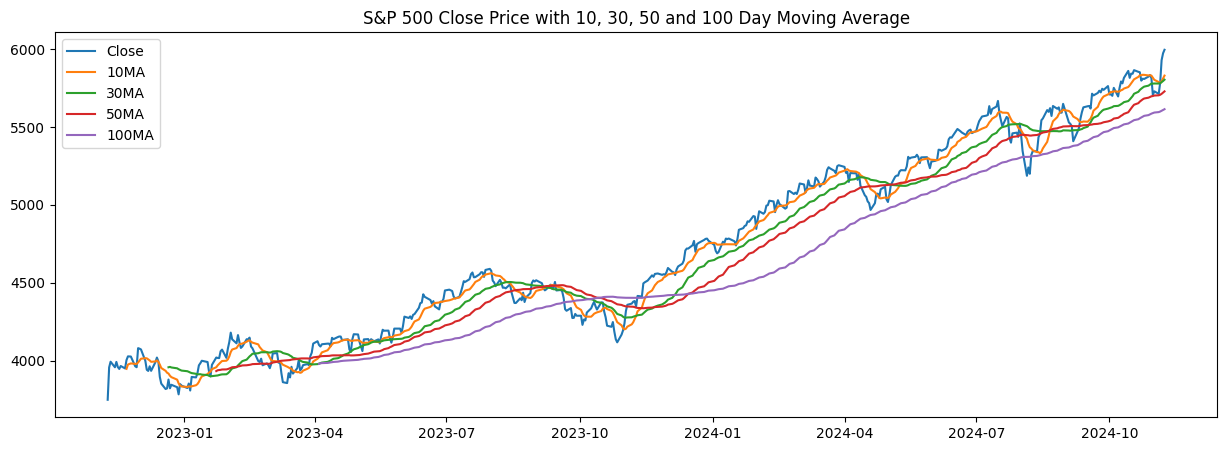

In [8]:
plt.figure(figsize=(15, 5))
plt.title('S&P 500 Close Price with 10, 30, 50 and 100 Day Moving Average')
plt.plot(df['Close'])
plt.plot(df['10ma'])
plt.plot(df['30ma'])
plt.plot(df['50ma'])
plt.plot(df['100ma'])
plt.legend(['Close','10MA', '30MA','50MA', '100MA'])
plt.show()

### La propuesta es acotar con las medias móviles, luego podría ser interesante fijarse en la volatidad que tiene la demanda

#### Otra propuesta interesante es hacer precciones del valor de demanda, y de las medias moviles; acotando los valores para que caiga en la zona común de ambas 

## En primer lugar vamos a hacer un EDA más exhaustivo el dataset

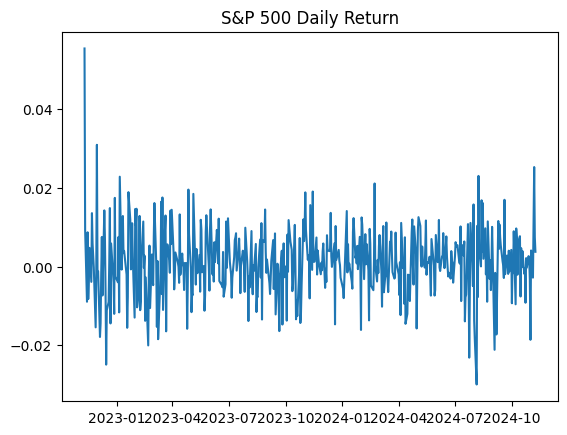

In [9]:
df['return']=df['Close'].pct_change()

#pct uses day as default 
plt.title('S&P 500 Daily Return')
plt.plot(df['return'])
plt.show()

## Se podría estudiar la estacionalidad  y tendencia de las ganancias diarias

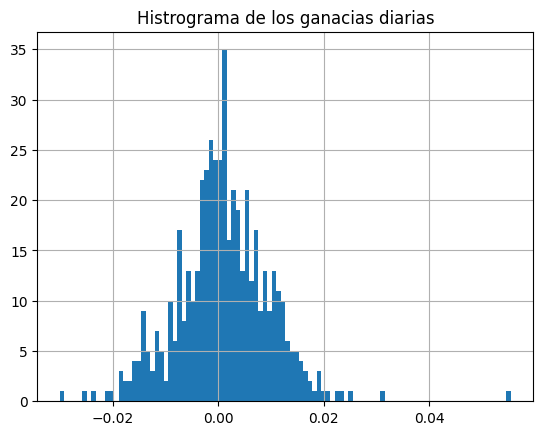

In [10]:
#Generamos el histograma para ver si se ajusta a una distribución normal

plt.title('Histrograma de los ganacias diarias')
df['return'].hist(bins=100)
plt.show()

### Volatilidad y rolling correlation

In [11]:
df['volatility']=df['return'].rolling(window=20).std()*(20**0.5)


In [12]:
df['volatility']

Date
2022-11-09 00:00:00-05:00         NaN
2022-11-10 00:00:00-05:00         NaN
2022-11-11 00:00:00-05:00         NaN
2022-11-14 00:00:00-05:00         NaN
2022-11-15 00:00:00-05:00         NaN
                               ...   
2024-11-04 00:00:00-05:00    0.029456
2024-11-05 00:00:00-05:00    0.030429
2024-11-06 00:00:00-05:00    0.038955
2024-11-07 00:00:00-05:00    0.039271
2024-11-08 00:00:00-05:00    0.039069
Name: volatility, Length: 503, dtype: float64

In [13]:
df['corr20']=df['return'].rolling(window=20).corr(df['volatility'])

In [14]:
df['corr20']

Date
2022-11-09 00:00:00-05:00         NaN
2022-11-10 00:00:00-05:00         NaN
2022-11-11 00:00:00-05:00         NaN
2022-11-14 00:00:00-05:00         NaN
2022-11-15 00:00:00-05:00         NaN
                               ...   
2024-11-04 00:00:00-05:00   -0.215016
2024-11-05 00:00:00-05:00   -0.131336
2024-11-06 00:00:00-05:00    0.426309
2024-11-07 00:00:00-05:00    0.428875
2024-11-08 00:00:00-05:00    0.411758
Name: corr20, Length: 503, dtype: float64

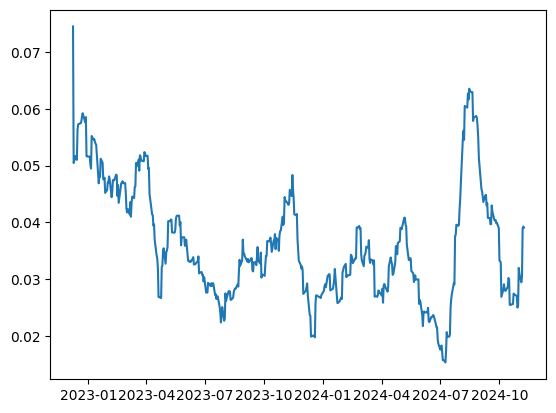

In [15]:
plt.plot(df['volatility'])

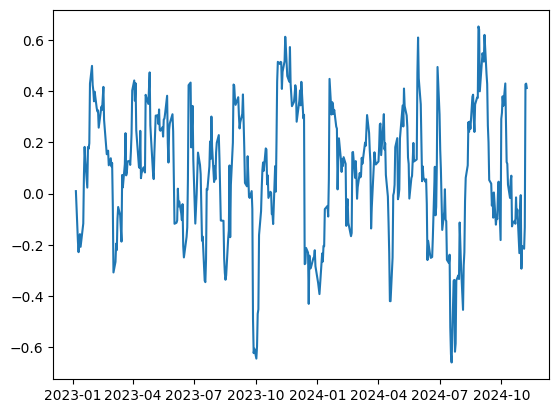

In [16]:
plt.plot(df['corr20'])

### Vemos si la volatidad se ajusta a una distribución normal 

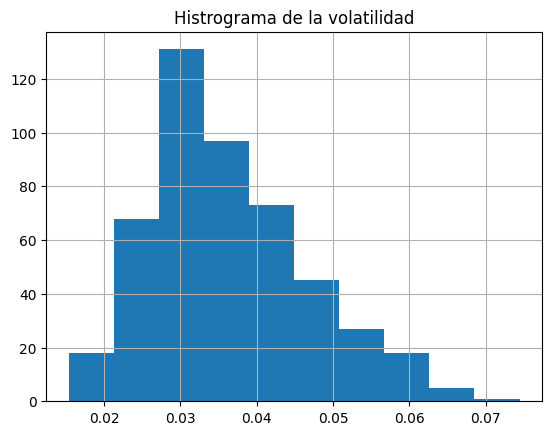

In [17]:
plt.title('Histrograma de la volatilidad')
df['volatility'].hist()
plt.show()

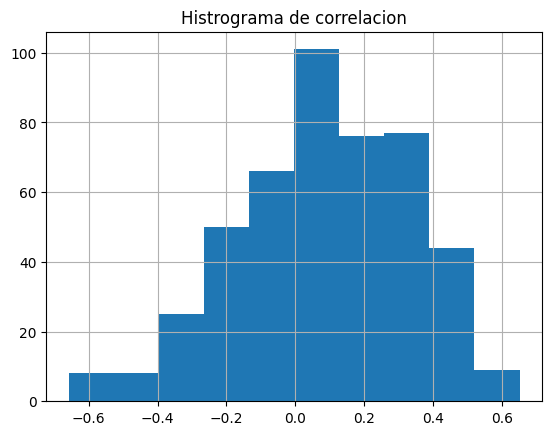

In [18]:
plt.title('Histrograma de correlacion')
df['corr20'].hist()
plt.show()

#### Vamos a descomponer la serie temporal y el hacer el test de fuller, ya que se observa la posibilidad de que haya cierta estacionalidad

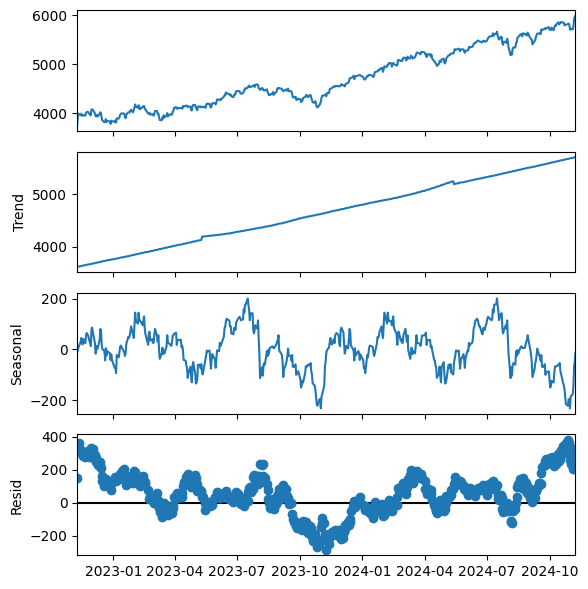

In [19]:

result_add = seasonal_decompose(df[['Close']], model='additive', period=251, extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_add.plot();

#### La tendencia esta limpia, comprobamos la seasonality

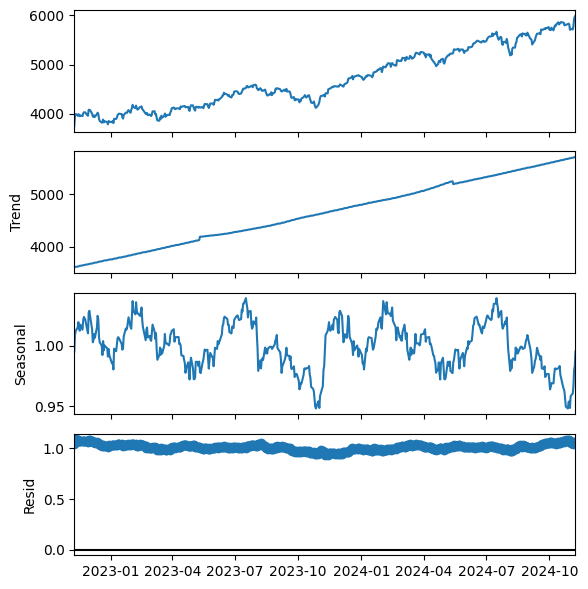

In [20]:
result_mul = seasonal_decompose(df[['Close']], model='multiplicative', period=251, extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_mul.plot();

In [21]:
df_reconstructed_ad = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis = 1)
df_reconstructed_mul = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis = 1)
df_reconstructed_ad.columns = ['seasonal', 'trend', 'resid', 'actual_values']
df_reconstructed_mul.columns = ['seasonal', 'trend', 'resid', 'actual_values']
df_reconstructed_ad

,seasonal,trend,resid,actual_values
Date,,,,
2022-11-09 00:00:00-05:00,-12.560723,3612.102153,149.028638,3748.570068
2022-11-10 00:00:00-05:00,-3.415721,3616.260906,343.524933,3956.370117
2022-11-11 00:00:00-05:00,8.727642,3620.419659,363.782631,3992.929932
2022-11-14 00:00:00-05:00,28.496542,3624.578412,304.175046,3957.250000
2022-11-15 00:00:00-05:00,44.979410,3628.737165,318.013406,3991.729980
...,...,...,...,...
2024-11-04 00:00:00-05:00,-177.772717,5685.844210,204.618448,5712.689941
2024-11-05 00:00:00-05:00,-143.093333,5690.013811,235.839288,5782.759766
2024-11-06 00:00:00-05:00,-67.966532,5694.183411,302.823160,5929.040039


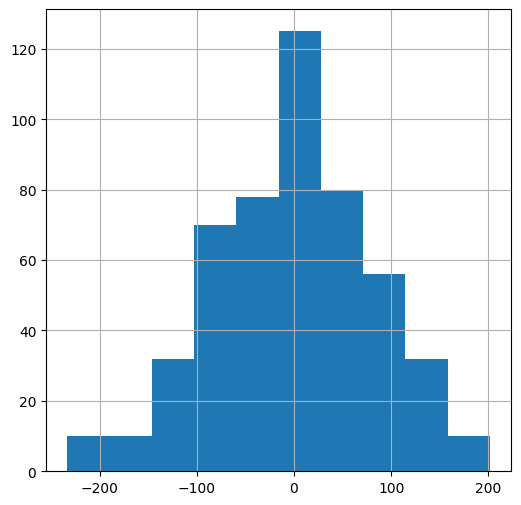

In [22]:
df_reconstructed_ad['seasonal'].hist()
plt.show()

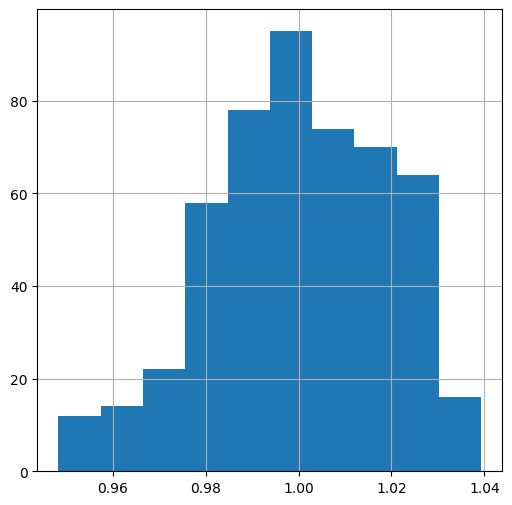

In [23]:
df_reconstructed_mul['seasonal'].hist()
plt.show()

In [24]:
result = adfuller(df['Close'].values)
print(result)

(-0.08612587205611555, 0.9508030357446204, 0, 502, {'1%': -3.4434437319767452, '5%': -2.8673146875484368, '10%': -2.569845688481135}, 4919.955130944294)


Al ser el valor de 0,94>0,05, rechazamos la hipótesis nula, con lo que la serie es no estacionaria

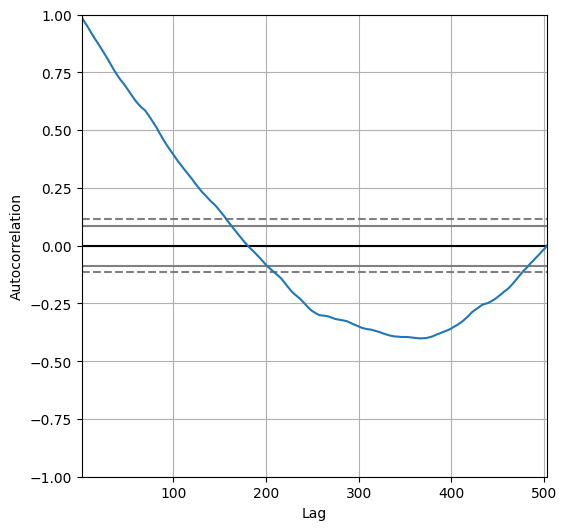

In [25]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Close'].values);

### Preparación del LSTM

In [26]:
df=df.reset_index()
df

,Date,Open,High,Low,Close,Volume,50ma,30ma,10ma,100ma,return,volatility,corr20
0,2022-11-09 00:00:00-05:00,3810.939941,3818.199951,3744.219971,3748.570068,4645010000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-11-10 00:00:00-05:00,3859.889893,3958.330078,3859.889893,3956.370117,5781260000,NaN,NaN,NaN,NaN,0.055434,NaN,NaN
2,2022-11-11 00:00:00-05:00,3963.719971,4001.479980,3944.820068,3992.929932,5593310000,NaN,NaN,NaN,NaN,0.009241,NaN,NaN
3,2022-11-14 00:00:00-05:00,3977.969971,4008.969971,3956.399902,3957.250000,4561930000,NaN,NaN,NaN,NaN,-0.008936,NaN,NaN
4,2022-11-15 00:00:00-05:00,4006.409912,4028.840088,3953.169922,3991.729980,5015310000,NaN,NaN,NaN,NaN,0.008713,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,2024-11-04 00:00:00-05:00,5725.149902,5741.430176,5696.509766,5712.689941,3602060000,5703.304561,5778.868311,5788.364990,5595.486797,-0.002812,0.029456,-0.215016
499,2024-11-05 00:00:00-05:00,5722.430176,5783.439941,5722.100098,5782.759766,3768310000,5706.622959,5780.529297,5781.520947,5598.976992,0.012266,0.030429,-0.131336
500,2024-11-06 00:00:00-05:00,5864.890137,5936.140137,5864.890137,5929.040039,6329530000,5712.687764,5787.421973,5794.682959,5603.951392,0.025296,0.038955,0.426309
501,2024-11-07 00:00:00-05:00,5947.209961,5983.839844,5947.209961,5973.100098,4925740000,5720.306162,5795.012972,5811.006982,5608.950093,0.007431,0.039271,0.428875


In [27]:
Y=df[['Date','Close']]
Y.rename(columns = {'Date':'ds'}, inplace = True)
Y.rename(columns = {'Close':'y'}, inplace = True)
Y

C:\Users\Adrian\AppData\Local\Temp\ipykernel_6108\711611463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y.rename(columns = {'Date':'ds'}, inplace = True)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_6108\711611463.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y.rename(columns = {'Close':'y'}, inplace = True)


,ds,y
0,2022-11-09 00:00:00-05:00,3748.570068
1,2022-11-10 00:00:00-05:00,3956.370117
2,2022-11-11 00:00:00-05:00,3992.929932
3,2022-11-14 00:00:00-05:00,3957.250000
4,2022-11-15 00:00:00-05:00,3991.729980
...,...,...
498,2024-11-04 00:00:00-05:00,5712.689941
499,2024-11-05 00:00:00-05:00,5782.759766
500,2024-11-06 00:00:00-05:00,5929.040039
501,2024-11-07 00:00:00-05:00,5973.100098


In [28]:
dataset=Y[['y']].values

In [29]:
scaler=MinMaxScaler(feature_range=(-1,0))
scaled_data=scaler.fit_transform(dataset)

In [30]:
# Defines the rolling window
look_back = 6
# Split into train and test sets
train, test = scaled_data[:int(0.90*len(Y))-look_back,:], scaled_data[int(0.90*len(Y))-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)
print(x_train.shape)

(440, 6)


In [31]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))


print((x_train.shape), (x_test.shape))

(440, 1, 6) (51, 1, 6)


In [ ]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
history=model.fit(x_train, y_train, batch_size=24, epochs=100, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])


model.summary()

c:\Users\Adrian\Documents\DATA_SCIENCE_BOOTCAMP\Moving_Average_Example\MovingAverage-LSTM\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.3314 - val_loss: 0.0657
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0243 - val_loss: 0.0444
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0162 - val_loss: 0.0573
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0348
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0051 

In [ ]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print('RMSE: {}'.format(score_rmse))
print('MAE: {}'.format(score_mae))

# Get the root mean squared error (RMSE) and MAE in train

score_rmse_train = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
score_mae_train = mean_absolute_error(y_train[0], train_predict[:,0])
print('RMSE: {}'.format(score_rmse_train))
print('MAE: {}'.format(score_mae_train))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE: 57.98860618056824
MAE: 47.964010799632355
RMSE: 72.90683003887716
MAE: 61.854190895774146


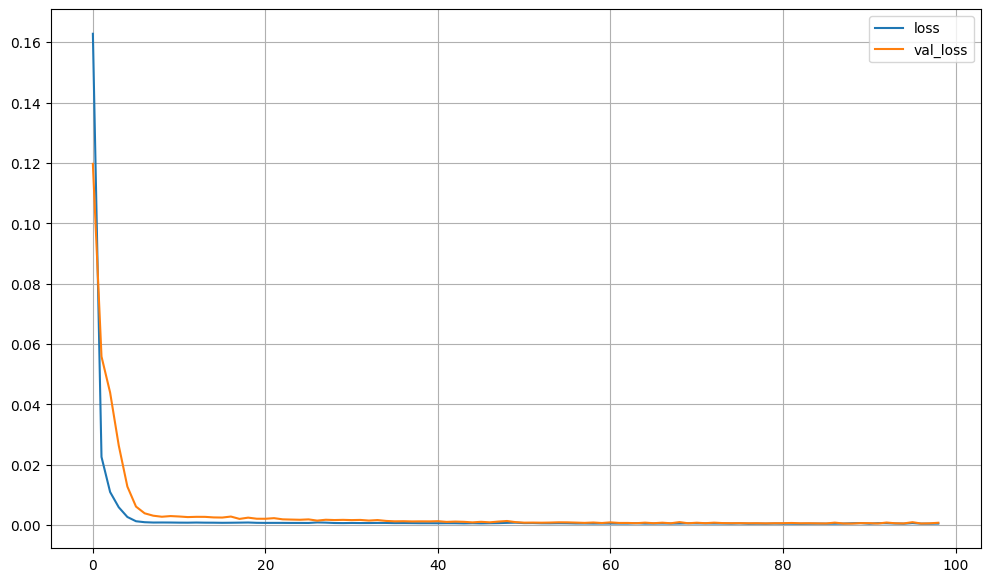

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12, 7))
plt.grid(True)
plt.show()

### Las líneas se cortan

In [ ]:
x_train_ticks = Y.head(int(0.90*len(Y)))['ds']
y_train = Y.head(int(0.90*len(Y)))['y']
x_test_ticks = Y.tail(int(0.10*len(Y)+1))['ds']

In [ ]:
y_train

0      3797.340088
1      3859.110107
2      3830.600098
3      3807.300049
4      3901.060059
          ...     
447    5240.029785
448    5199.500000
449    5319.310059
450    5344.160156
451    5344.390137
Name: y, Length: 452, dtype: float64

In [ ]:
x_train_ticks

0     2022-10-24 00:00:00-04:00
1     2022-10-25 00:00:00-04:00
2     2022-10-26 00:00:00-04:00
3     2022-10-27 00:00:00-04:00
4     2022-10-28 00:00:00-04:00
                 ...           
447   2024-08-06 00:00:00-04:00
448   2024-08-07 00:00:00-04:00
449   2024-08-08 00:00:00-04:00
450   2024-08-09 00:00:00-04:00
451   2024-08-12 00:00:00-04:00
Name: ds, Length: 452, dtype: datetime64[ns, America/New_York]

In [ ]:
train_predict.shape

(440, 1)

In [ ]:
y_train

0      3797.340088
1      3859.110107
2      3830.600098
3      3807.300049
4      3901.060059
          ...     
447    5240.029785
448    5199.500000
449    5319.310059
450    5344.160156
451    5344.390137
Name: y, Length: 452, dtype: float64

Text(0, 0.5, 'S&P500')

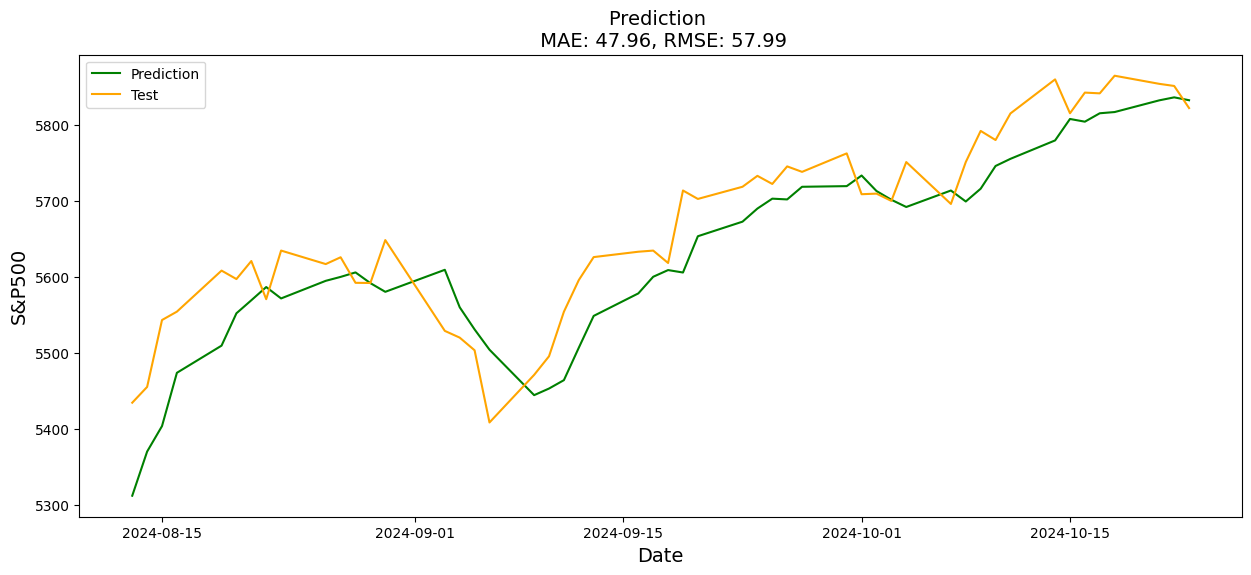

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

#sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Test') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='S&P500', fontsize=14)